In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
import os
import sys

sys.path.append("../lib/TrackObs/")
sys.path.append("../lib/CosmicObservation/")

from CosmicObservation import *
from external_flux import *
from astropy.io import fits

import glob
import re

In [3]:
getobmt = lambda x: int(re.search("(?<=OBMT_START_)[0-9]+",x).group(0))

# Get the paths

In [4]:
# get all paths
smpaths = glob.glob("../output/CosmicObservations/*/*/*/SM-SIF_OBMT_START_*.fits")
smpaths.sort(key = getobmt)

bamobspaths = glob.glob("../output/CosmicObservations/*/*/*/BAM-OBS*_OBMT_START_*.fits")
bamobspaths.sort(key = getobmt)

bamsifpaths = glob.glob("../output/CosmicObservations/*/*/*/BAM-SIF_OBMT_START_*.fits")
bamsifpaths.sort(key = getobmt)

In [5]:
def psel_rev(allpaths,start,stop):
    pathtimes_rev = np.array([getobmt(p) for p in allpaths])/(1e9*3600*6)
    indices = np.where(np.logical_and(pathtimes_rev>=start, pathtimes_rev<=stop))[0]
    return [allpaths[ii] for ii in indices]


def psel_mjd(allpaths,start,stop):
    pathtimes_mjd = OBMT_apyTime(np.array([getobmt(p) for p in allpaths])).mjd
    indices = np.where(np.logical_and(pathtimes_mjd>=start, pathtimes_mjd<=stop))[0]
    return [allpaths[ii] for ii in indices]

# Energy histograms

In [12]:
def CosObs_get_energies(filenames,edgeless=False,row=-1,fov=-1):
    """Return a dictionary 
        En: [list of list of energies per observation]
        flux: [list of flux per observation]
    """
    
    # Create output dict
    outdict = {'EN':[], 'FLUX':[]}
    
    # if the input is not a list, it has to be a single filename
    if type(filenames) != type([]):
        filenames = [filenames]
    
    for filename in filenames:
        # Open the file
        hdulist = fits.open(filename)
        
        # Iterate over all the CosmicObservations
        for ii in range(1,len(hdulist),1):
            head = hdulist[ii].header
            
            # filter if necessary
            if fov > 0:
                if head["FOV"] != fov: continue
            if row > 0:
                if head["CCD_ROW"] != row: continue
                    
            # write flux
            outdict['FLUX'].append(head["FLUX"])
            
            if edgeless:
                edgecosmics = hdulist[ii].data["TRACK_TRUNCATED"]
                # write energies and rejected
                outdict['EN'].append( list((hdulist[ii].data["TRACK_EN"])[np.logical_not(edgecosmics)]) )
            else:
                # write energies and rejected
                outdict['EN'].append( list(hdulist[ii].data["TRACK_EN"]) )

        # Close the file
        hdulist.close()
    return outdict

In [13]:
bamobs_dat = CosObs_get_energies(bamobspaths[0:2],fov=1,edgeless=True)
sm_dat = CosObs_get_energies(smpaths[:10],edgeless=True)
bamsif_dat = CosObs_get_energies(bamsifpaths,edgeless=True)

Test: Instead of normalizing by the total number of particles, take the flux into account as well

In [14]:
def energyHist_fluxnormed(obsEn, obsFluxes, bins=None, enrange=None):
    """
    Given a list of energy lists and a list of the fluxes of the corresponding observations,
    make a normed energy histogram - each observation is normed by its geometry factor and then averaged over
    The output histogram is counts/cm^2/s/eV
    """
    nobs = len(obsFluxes)
    Eflat = sum(obsEn, [])
    normflat = np.empty(len(Eflat))
    
    # determine the weights
    start = 0
    for ii in range(nobs):
        nParticles = len(obsEn[ii])
        normflat[start:start+nParticles] = obsFluxes[ii]/nParticles
        start += +nParticles
    
    normflat /= nobs
    # compute the weighted histogram
    histout = np.histogram(Eflat,bins=bins,range=enrange, weights=normflat)
    
    # divide by bin size
    step = histout[1][1] - histout[1][0]
    #step=1
    
    return histout[0]/step, histout[1]

In [15]:
nhistbam_obs = energyHist_fluxnormed(bamobs_dat['EN'],bamobs_dat['FLUX'],200,(0,40000))
nhistbam_sif = energyHist_fluxnormed(bamsif_dat['EN'],bamsif_dat['FLUX'],200,(0,40000))
nhist_sm = energyHist_fluxnormed(sm_dat['EN'],sm_dat['FLUX'],200,(0,40000))

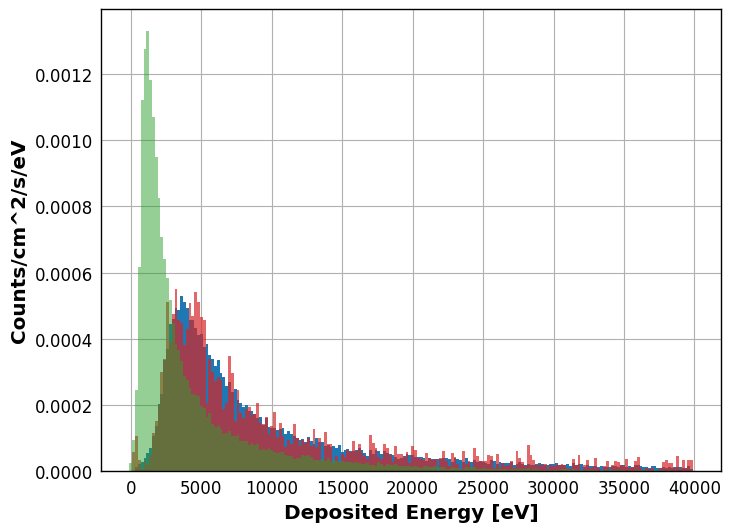

In [16]:
hists = [nhistbam_obs, nhistbam_sif, nhist_sm]
colors = ["tab:blue", "tab:red", "tab:green"]
alphas = [1,0.7,0.5]

for ii in range(len(hists)):
    h = hists[ii]
    plt.bar(h[1][:-1], h[0], h[1][1]-h[1][0], color=colors[ii], alpha=alphas[ii])

plt.xlabel("Deposited Energy [eV]")
plt.ylabel("Counts/cm^2/s/eV")

#plt.yscale('log')